In [23]:
%cd /Users/gwg/dmcm

/Users/gwg/dmcm


In [24]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from   PIL import Image
plt.style.use('seaborn-deep')
import seaborn as sns

# from   data import GTExV8Config, GTExV8Dataset, loader
from   data import GTExConfig, GTExDataset, loader
from   models import DPCCA

In [25]:
%matplotlib inline

In [26]:
cfg = GTExConfig()

# directory = 'experiments/20190131_big_sweep/'\
#             'gtexv8_mode-dpcca_batch_size-128_seed-0_latent_dim-10_lr-0.0001_l1_coef-0.5_em_iters-1_clip-1'

directory = 'experiments/20190305_gtexv6_celeba/'\
            'gtex_mode-dpcca_seed-0_latent_dim-10_lr-0.0001_l1_coef-0.0_em_iters-1'

state = torch.load(directory + '/model.pt', map_location={'cuda:0': 'cpu'})
model = DPCCA(cfg, latent_dim=10, use_gene_net=True)
model.load_state_dict(state)

In [27]:
train_loader, test_loader = loader.get_data_loaders(cfg,
                                                    batch_size=128,
                                                    num_workers=1,
                                                    pin_memory=False,
                                                    directory=directory)
dataset = train_loader.dataset

In [28]:
print(len(dataset))

2221


In [29]:
inds = train_loader.sampler.indices
# The indices were generated through random shuffling, so this shouldn't bias anything.
inds = inds[:600]
n    = len(inds)
print(n)

# inds = range(0, len(dataset))
# n    = len(inds)

X1 = torch.Tensor(n, cfg.N_CHANNELS, cfg.IMG_SIZE, cfg.IMG_SIZE)
X2 = torch.Tensor(n, cfg.N_GENES)
labels = torch.Tensor(n)
tissues = []

for j, i in enumerate(inds):
    x1, x2 = dataset[i]
    X1[j] = x1
    X2[j] = x2
    labels[j] = float(dataset.labels[i])
    tissues.append(dataset.tissues[i])

tissues = np.array(tissues)

600


In [30]:
Zs = model.estimate_z_given_x([X1, X2], threshold=None)
print(X1.shape)
print(X2.shape)
print(Zs.shape)

torch.Size([600, 3, 128, 128])
torch.Size([600, 18659])
torch.Size([600, 30])


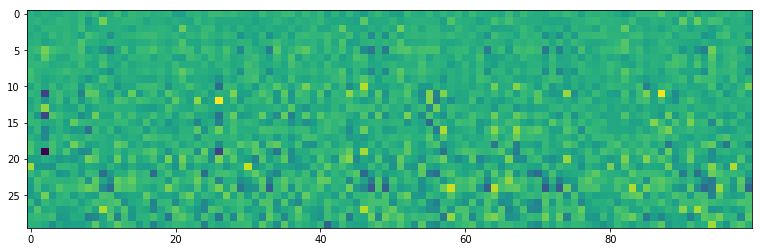

In [31]:
Zs = Zs.detach()
Zs.shape

fig, ax = plt.subplots(figsize=(22, 4))
ZSs = Zs#[:, :10]
ax.imshow(ZSs[:100].t())

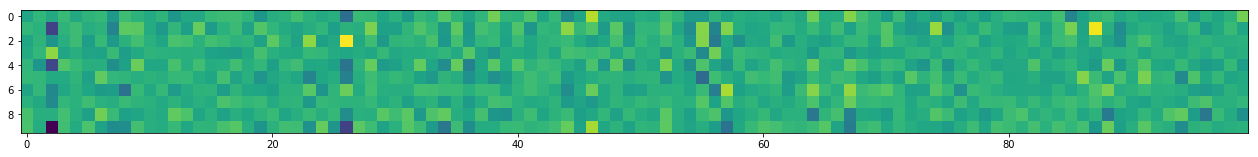

In [32]:
Z1s = Zs[:, 10:20]
fig, ax = plt.subplots(figsize=(22, 4))
ax.imshow(Z1s[:100].t(), interpolation='nearest')

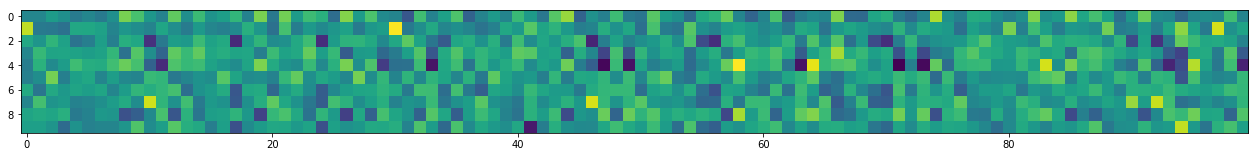

In [33]:
Z2s = Zs[:, 20:]
fig, ax = plt.subplots(figsize=(22, 4))
ax.imshow(Z2s[:100].t(), interpolation='nearest')

In [34]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

<class 'torch.Tensor'>


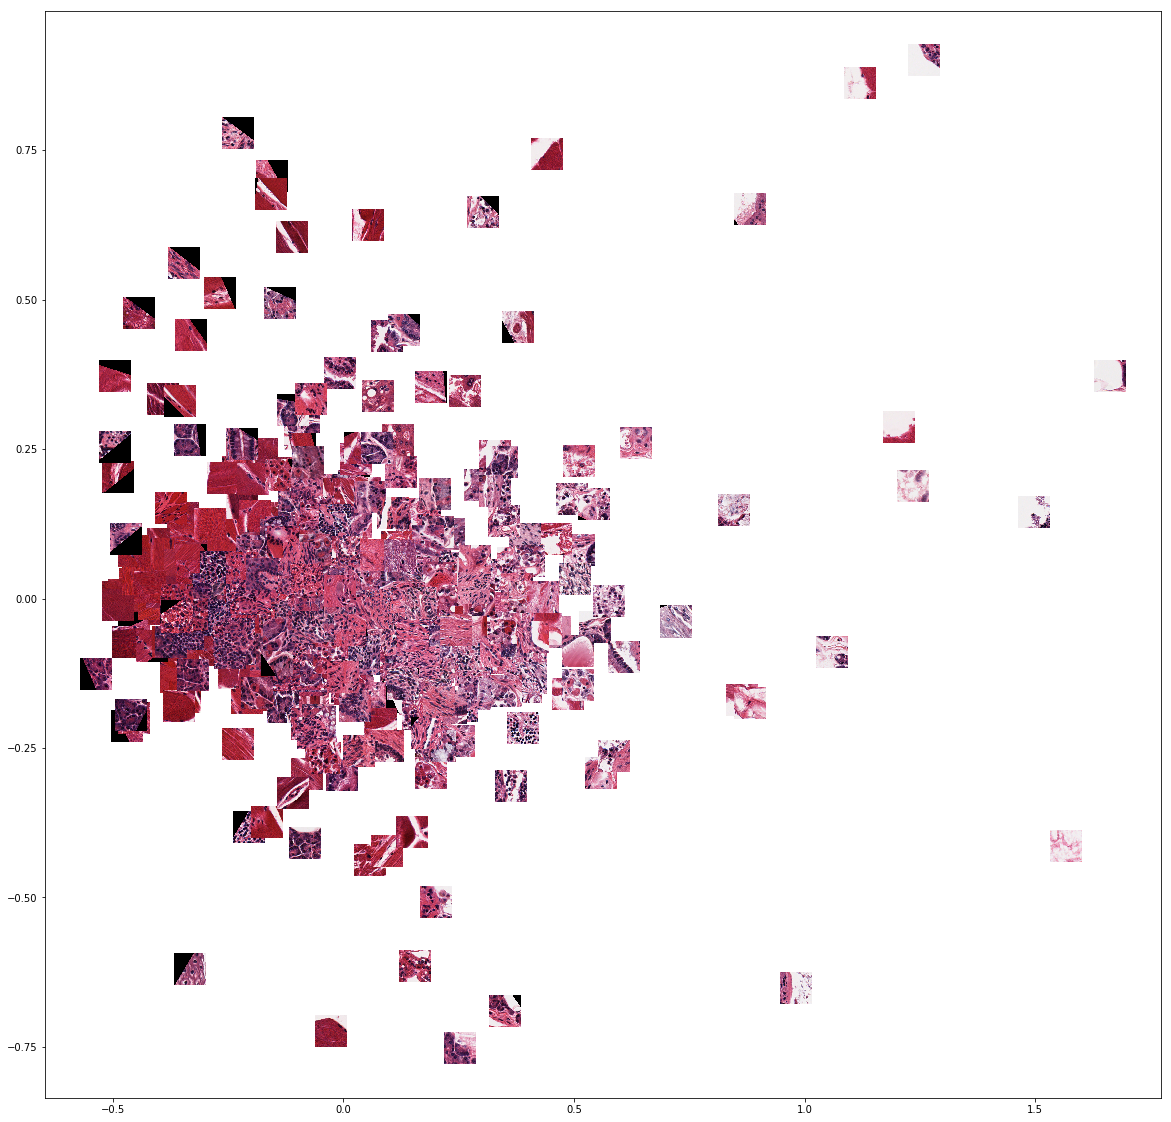

In [35]:
from sklearn.decomposition import PCA

decompressor = PCA(n_components=2)
Zs_pca = decompressor.fit_transform(Zs[:, 10:20])

fig, ax = plt.subplots(figsize=(20, 20))

print(type(X1))

for i in np.unique(labels):
    inds = labels.numpy() == i
    for img, data in zip(X1.numpy()[inds], Zs_pca[inds]):
        imscatter(data[0], data[1], img.T, ax, zoom=0.25)

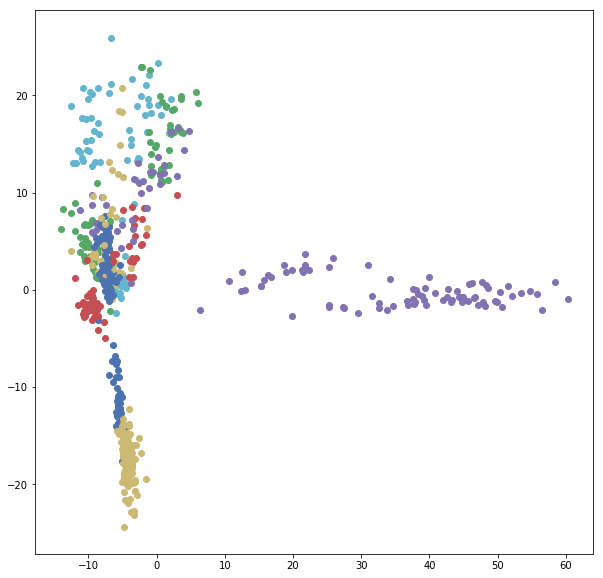

In [36]:
# ne = model.image_net.encode(X1).detach().numpy()
ne = model.genes_net.encode(X2).detach().numpy()

ne2_pca = decompressor.fit_transform(ne)
fig, ax = plt.subplots(figsize=(10, 10))

for i in np.unique(labels):
    inds = labels.numpy() == i
    data = ne2_pca[inds]
    ax.scatter(data[:, 0], data[:, 1], label=i)

In [37]:
print(Zs.shape)

torch.Size([600, 30])


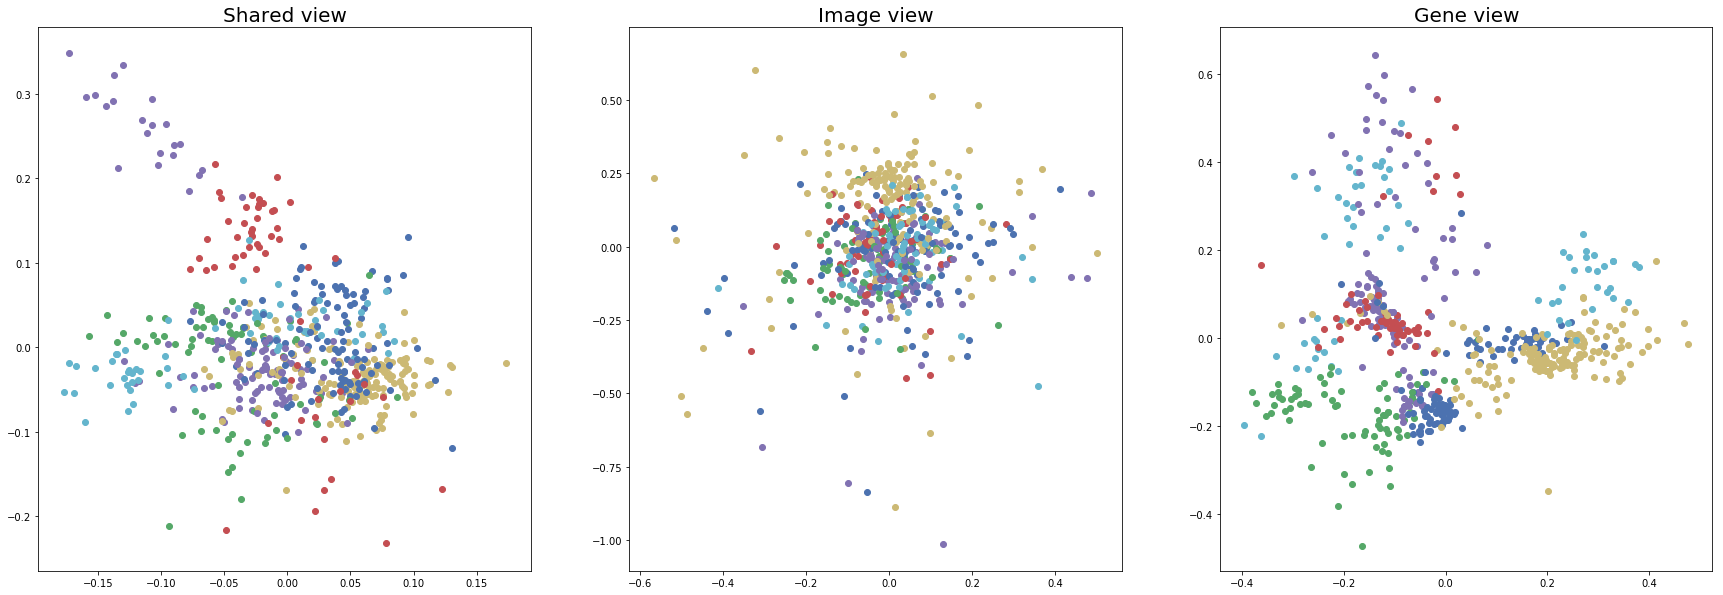

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
from sklearn.decomposition import PCA

uniq_labels = np.unique(labels)
sns.set_palette('hls', 29)
colors = sns.color_palette()

for (i,j), ax, title in zip([(0, 10), (10, 20), (20, 30)],
                            axes.flat,
                            ['Shared view', 'Image view', 'Gene view']):
    Zs_view = Zs[:, i:j]
    for i, col in zip(uniq_labels, colors):
        inds = labels.numpy() == i
        data = Zs_view.numpy()[inds]
        ax.scatter(data[:, 0], data[:, 1], label=i)
        ax.set_title(title, fontsize=20)

29


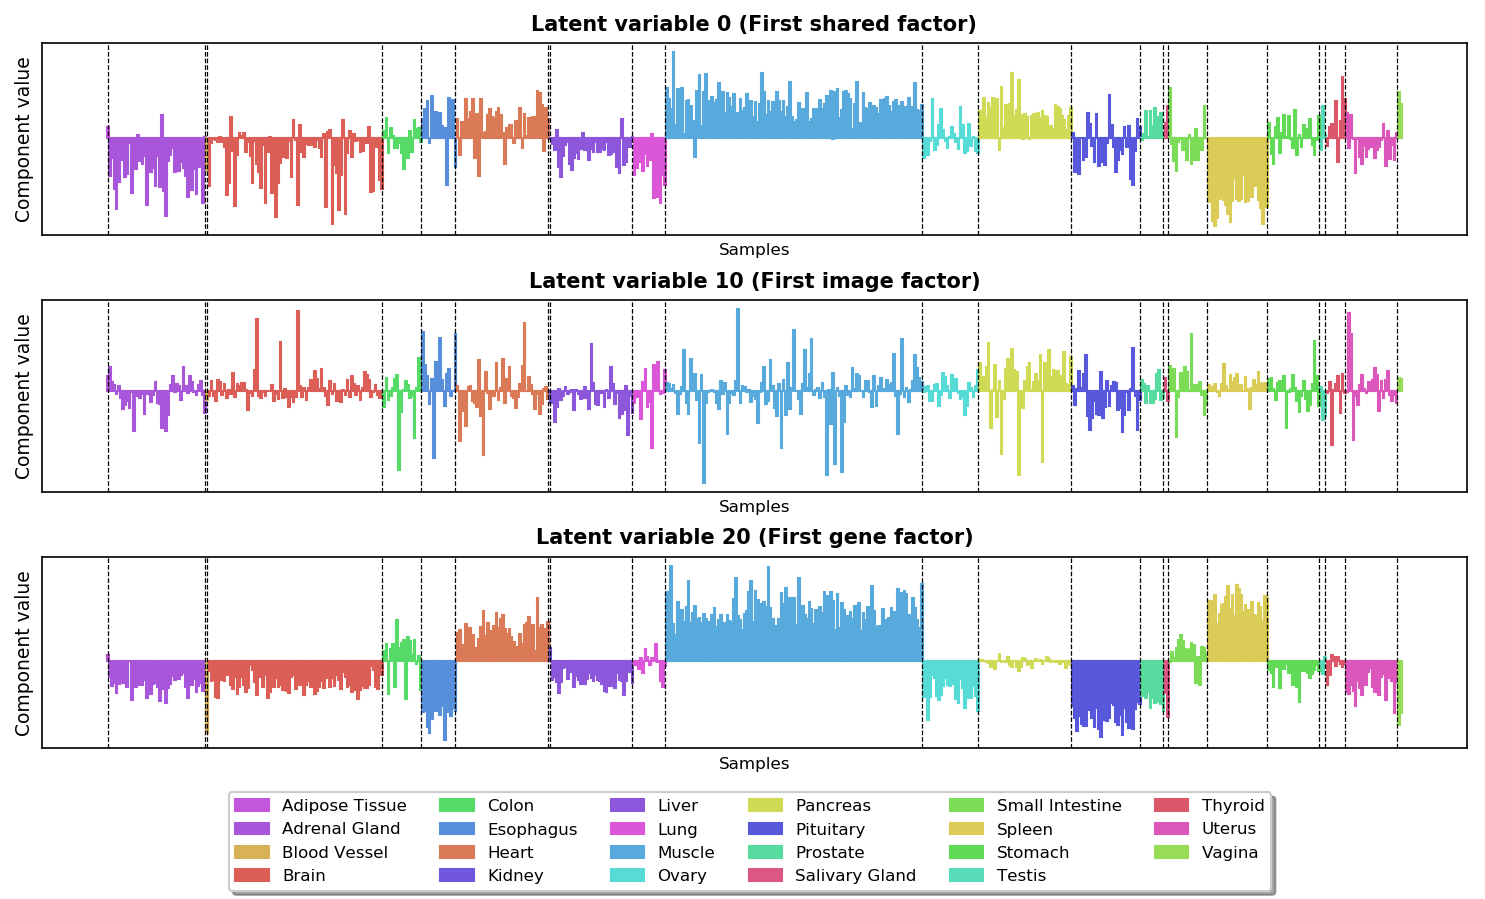

In [39]:
factors = [0, 10, 20]
fig, axes = plt.subplots(3, 1, dpi=150)
fig.set_size_inches(10, 6)

# n_colors = len(np.unique(labels))
# cm = plt.cm.get_cmap('tab20c', n_colors)
# colors = cm.colors
# np.random.shuffle(colors)  # inplace
# colors = [plt.cm.get_cmap('Spectral')(i) for i in range(n_colors)]

inds          = np.argsort(labels)
labels_sorted = labels[inds].numpy()
tiss_sorted   = tissues[inds]
Zs_sorted     = Zs.numpy()[inds]

print(len(np.unique(dataset.tissues)))

sns.set_palette('hls', 29)
colors = sns.color_palette()
np.random.shuffle(colors)
titles = ['First shared factor', 'First image factor', 'First gene factor']
# titles = ['%s shared factor' % i for i in range(10)]

for ax, factor_idx, title in zip(axes.flat, factors, titles):

    zk = Zs_sorted[:, factor_idx]
    curr_label = labels_sorted[0]
    j = 0
    curr_color = colors[j]

    labels_added = []

    for i, z in enumerate(Zs_sorted):
        if curr_label != labels_sorted[i]:
            curr_label = labels_sorted[i]
            j += 1
            curr_color = colors[j]
            ax.axvline(x=i-1, color='k', linestyle='--', linewidth=0.6)

        curr_tiss = tiss_sorted[i]
        if curr_tiss not in labels_added:
            labels_added.append(curr_tiss)
            ax.bar(i, zk[i], label=curr_tiss, color=curr_color, edgecolor=curr_color)
        else:
            ax.bar(i, zk[i], color=curr_color, edgecolor=curr_color)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Latent variable %s (%s)' % (factor_idx, title), fontsize=10, fontweight='bold')
    ax.set_xlabel('Samples', fontsize=8)
    ax.set_ylabel('Component value', fontsize=9)

plt.tight_layout()
handles, plt_labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, plt_labels, loc='lower center', ncol=6,
                 shadow=True, bbox_to_anchor=(0.5, 0), prop={'size': 8})
fig.subplots_adjust(bottom=0.16)

In [42]:
from scipy.stats import ttest_1samp

factor_idx = 0
zk         = Zs_sorted[:, 20]
curr_tiss  = 'Adrenal Gland'
curr_samps = []
threshold  = 0.05

stat_pvalues = []
stat_tissues = []

for tiss in np.unique(tiss_sorted):
    inds = np.array(tiss_sorted) == tiss
    z_curr = zk[inds]    
    stat = ttest_1samp(z_curr, popmean=0)
    
    # Bonferroni corrected threshold:
    corrected_threshold = threshold / len(z_curr)
    if stat.pvalue < corrected_threshold:
        stat_pvalues.append(stat.pvalue)
        stat_tissues.append(tiss)

inds         = np.argsort(stat_pvalues)
stat_pvalues = np.array(stat_pvalues)[inds]
stat_tissues = np.array(stat_tissues)[inds]

chunk_pvalues = np.array_split(stat_pvalues, 3)
chunk_tissues = np.array_split(stat_tissues, 3)

for pvals, tiss in zip(chunk_pvalues, chunk_tissues):
    print(pvals, tiss)

[1.57958351e-68 7.78675044e-40 8.62658758e-26 1.42626249e-21
 1.79958175e-21] ['Muscle' 'Brain' 'Pituitary' 'Spleen' 'Adrenal Gland']
[3.27427538e-18 1.08219099e-17 7.51166345e-14 2.77400546e-12] ['Heart' 'Liver' 'Ovary' 'Esophagus']
[6.29296075e-11 3.19892333e-09 1.60007184e-07 7.84640248e-04] ['Uterus' 'Prostate' 'Stomach' 'Pancreas']
